Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.3MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1/50, D Loss: 0.4495, G Loss: 0.9712
Epoch 2/50, D Loss: 0.4660, G Loss: 1.5866
Epoch 3/50, D Loss: 0.4938, G Loss: 1.5181
Epoch 4/50, D Loss: 0.5321, G Loss: 0.6566
Epoch 5/50, D Loss: 0.6061, G Loss: 2.3308
Epoch 6/50, D Loss: 0.4157, G Loss: 1.6827
Epoch 7/50, D Loss: 0.5787, G Loss: 2.7624
Epoch 8/50, D Loss: 0.3758, G Loss: 1.0976
Epoch 9/50, D Loss: 0.4201, G Loss: 1.8768
Epoch 10/50, D Loss: 0.3430, G Loss: 1.0476
Epoch 11/50, D Loss: 0.3628, G Loss: 2.1029
Epoch 12/50, D Loss: 0.3955, G Loss: 1.5316
Epoch 13/50, D Loss: 0.4330, G Loss: 1.4437
Epoch 14/50, D Loss: 0.4952, G Loss: 0.9326
Epoch 15/50, D Loss: 0.3586, G Loss: 1.3036
Epoch 16/50, D Loss: 0.5132, G Loss: 1.5026
Epoch 17/50, D Loss: 0.5382, G Loss: 0.6489
Epoch 18/50, D Loss: 0.4695, G Loss: 1.3835
Epoch 19/50, D Loss: 0.4985, G Loss: 1.7103
Epoch 20/50, D Loss: 0.5902, G Loss: 0.6803
Epoch 21/50, D Loss: 0.5256, G Loss: 0.7855
Epoch 22/50, D Loss:

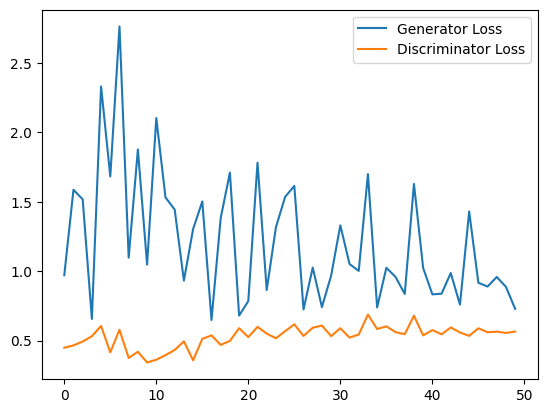

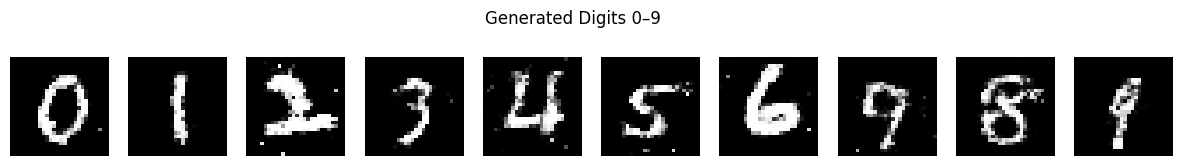

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
latent_dim = 100
num_classes = 10
image_shape = (1, 28, 28)
batch_size = 128
epochs = 50
lr = 0.0002

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MNIST
dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(image_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, self.label_emb(labels)), -1)
        img = self.model(x)
        return img.view(img.size(0), *image_shape)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        return self.model(x)

# Initialize
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training
G_losses, D_losses = [], []

for epoch in range(epochs):
    for imgs, labels in dataloader:
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ------------------
        # Train Generator
        # ------------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Plot losses
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.show()

# Generate digits 0–9
generator.eval()
z = torch.randn(10, latent_dim).to(device)
labels = torch.arange(0, 10).to(device)
gen_imgs = generator(z, labels)
gen_imgs = gen_imgs.cpu().detach().numpy()

# Plot generated digits
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(gen_imgs[i][0], cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Digits 0–9")
plt.show()